# AI-Compass: "Next Best Action" Tactical Roadmap
### Strategic Rationale
Static scores tell you where you are. A **Strategic Roadmap** tells you how to grow. 

**This notebook implements a Hybrid Success Pathway:**
1.  **Success Trajectory (k-NN)**: We don't just find random neighbors; we find "Lookalikes" who are **15-30% more mature**. They represent the "Future You".
2.  **Thematic Weighted Gap Analysis**: We analyze the "Tactical Headers" (e.g., 'Leadership Alignment') and expert weights to find high-ROI actions.
3.  **Phased Roadmap**: We organize recommendations into a logical chronological flow:
    -   **Phase 1: Foundation** (Strategy, Data, Culture)
    -   **Phase 2: Implementation** (Infrastructure, Use Cases)
    -   **Phase 3: Optimization** (Processes, Governance)


In [22]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from dotenv import load_dotenv
import psycopg2

# Visualization
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 7]

# DB Connection
load_dotenv()
db_url = os.getenv("DATABASE_URL")
conn = psycopg2.connect(db_url)
print("✓ Connected to Database")


✓ Connected to Database


## 1. SUCCESS DATA PREPARATION

In [23]:
query = """
SELECT 
    r.company_id,
    d.dimension_name,
    q.header as tactical_theme,
    q.question_text,
    q.weight as question_weight,
    a.answer_weight
FROM response_items ri
JOIN responses r ON r.response_id = ri.response_id
JOIN questions q ON q.question_id = ri.question_id
JOIN dimensions d ON d.dimension_id = q.dimension_id
JOIN answers a ON a.answer_id = ri.answers[1]
WHERE d.dimension_name != 'General Psychology'
"""

df_raw = pd.read_sql(query, conn)

# 1. Dimension Level Features (1-5 Scale)
df_features = df_raw.groupby(['company_id', 'dimension_name'])['answer_weight'].mean().reset_index()
df_features = df_features.pivot(index='company_id', columns='dimension_name', values='answer_weight').fillna(0)
df_features = 1 + 4 * (df_features - df_features.min()) / (df_features.max() - df_features.min())
df_features['total_maturity'] = df_features.mean(axis=1)

# 2. Weighted Question Analysis
df_raw['weighted_gap'] = df_raw['question_weight'] * (5.0 - df_raw['answer_weight'])

print(f"Dataset prepared with {len(df_features)} companies and thematic metadata.")
df_features.head()


/var/folders/s4/gzyj3_ks2_s0smrmyspjtc2h0000gn/T/ipykernel_4531/2321137545.py:17: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_raw = pd.read_sql(query, conn)


Dataset prepared with 500 companies and thematic metadata.


dimension_name,Data Readiness & Literacy,Governance & Compliance,People & Culture,Processes & Scaling,Strategy & Business Vision,Tech Infrastructure,Use Cases & Business Value,total_maturity
company_id,,,,,,,,
3,2.703704,1.800000,3.00,2.25,2.75,2.787234,2.25,2.505848
4,3.296296,2.066667,2.25,1.75,2.00,2.872340,1.75,2.283615
6,3.000000,1.533333,2.00,2.00,1.75,2.787234,1.75,2.117224
9,2.481481,1.800000,1.25,2.00,2.25,1.595745,2.75,2.018175
10,3.000000,2.600000,2.25,3.00,2.50,1.255319,1.75,2.336474


## 2. HYBRID ROADMAP GENERATION

In [24]:
# Training basic KNN
X = df_features.drop(columns=['total_maturity'])
knn = NearestNeighbors(n_neighbors=15, metric='cosine') # Cosine for shape-based lookalikes
knn.fit(X)

def generate_tactical_roadmap(company_id):
    # 1. Find Success Lookalikes
    target_idx = df_features.index.get_loc(company_id)
    target_scores = X.iloc[target_idx]
    target_maturity = df_features.loc[company_id, 'total_maturity']
    
    distances, indices = knn.kneighbors(X.iloc[target_idx].values.reshape(1, -1))
    neighbor_ids = df_features.index[indices[0]]
    
    success_peers = df_features.loc[neighbor_ids]
    success_peers = success_peers[
        (success_peers['total_maturity'] > target_maturity) & 
        (success_peers['total_maturity'] <= target_maturity * 1.3)
    ]
    
    if success_peers.empty:
        success_peers = df_features.loc[neighbor_ids]
        success_peers = success_peers[success_peers['total_maturity'] > target_maturity]

    if success_peers.empty:
        return ["Stay the course: Your current trajectory is industry-leading.", "Innovation: Explore generative AI edge cases.", "Mentorship: Share best practices with subsidiaries."]

    peer_avg = success_peers.drop(columns=['total_maturity']).mean()
    dim_gaps = (peer_avg - target_scores).sort_values(ascending=False)
    
    phases = {
        'Phase 1: Foundation': ['Strategy & Business Vision', 'Data Readiness & Literacy', 'People & Culture'],
        'Phase 2: Implementation': ['Tech Infrastructure', 'Use Cases & Business Value'],
        'Phase 3: Scale & Governance': ['Processes & Scaling', 'Governance & Compliance']
    }
    
    roadmap = []
    target_items = df_raw[df_raw['company_id'] == company_id]
    
    for phase_name, dimensions in phases.items():
        phase_items = target_items[target_items['dimension_name'].isin(dimensions)].sort_values(['question_weight', 'weighted_gap'], ascending=False)
        
        if not phase_items.empty:
            top_theme = phase_items.iloc[0]
            action_text = f"**{phase_name}** | Target Capability: **{top_theme['tactical_theme']}** (Strategic Priority: {top_theme['question_weight']:.1f}). Focus on maturing this area to align with success-tier benchmarks."
            roadmap.append(action_text)
            
    return roadmap


## 3. NARRATIVE SYNTHESIS (LLM-READY)

In [25]:
def synthesize_roadmap_narrative(company_id):
    roadmap = generate_tactical_roadmap(company_id)
    
    return f"""
    ### 🗺️ The Consultant's Perspective: Your Transformation Path
    
    Your roadmap is designed to transition your organization from initial experimentation to **Sustainable Scaling**. 
    The immediate priority in **{roadmap[0].split('| ')[1] if '| ' in roadmap[0] else roadmap[0]}** is critical because it 
    builds the necessary alignment required for more complex technical implementations.
    
    Following this structured sequence ensures that you move at the speed of your people, 
    minimizing friction and maximizing the return on your AI investment.
    """

test_cid = df_features.index[17]
print(synthesize_roadmap_narrative(test_cid))



    ### 🗺️ The Consultant's Perspective: Your Transformation Path

    Your roadmap is designed to transition your organization from initial experimentation to **Sustainable Scaling**. 
    The immediate priority in **Target Capability: **Leadership Alignment** (Strategic Priority: 4.5). Focus on maturing this area to align with success-tier benchmarks.** is critical because it 
    builds the necessary alignment required for more complex technical implementations.

    Following this structured sequence ensures that you move at the speed of your people, 
    minimizing friction and maximizing the return on your AI investment.
    


/Users/christianmiething/Downloads/ai-compass/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


## 4. VISUALIZING THE HORIZON

/Users/christianmiething/Downloads/ai-compass/.venv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


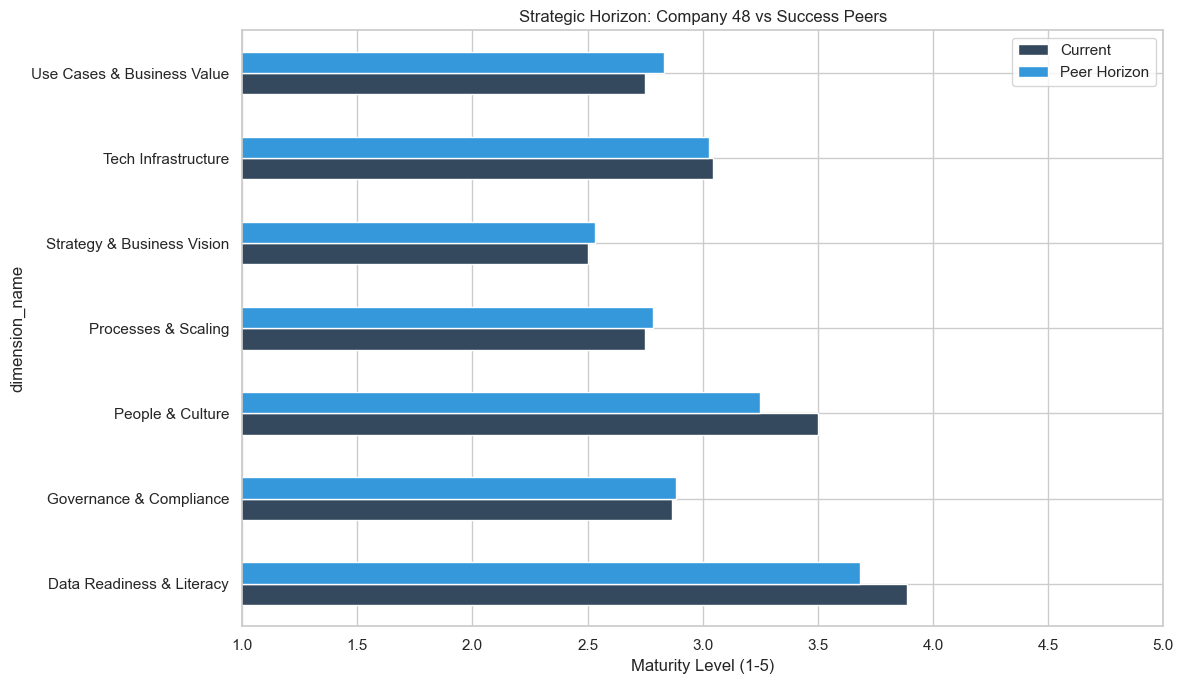

In [26]:
def plot_roadmap_potential(company_id):
    target_scores = X.loc[company_id]
    
    # Find neighbors
    distances, indices = knn.kneighbors(X.loc[company_id].values.reshape(1, -1))
    peer_avg = df_features.iloc[indices[0]].drop(columns=['total_maturity']).mean()
    
    # Radar-style comparison
    pd.DataFrame({
        'Current': target_scores,
        'Peer Horizon': peer_avg
    }).plot(kind='barh', color=['#34495e', '#3498db'])
    
    plt.title(f"Strategic Horizon: Company {company_id} vs Success Peers")
    plt.xlabel("Maturity Level (1-5)")
    plt.xlim(1, 5)
    plt.tight_layout()
    plt.show()

test_cid = df_features.index[17]
plot_roadmap_potential(test_cid)


## 5. Strategic Conclusion: From Map to Motion

### 1. Moving Beyond Static Scores
A maturity score is a snapshot in time. The **Strategic Roadmap** transforms this snapshot into a three-dimensional transformation path. By using k-NN lookalikes, we provide proof-of-concept for the user's future: "Companies like yours, who are already 20% more mature, prioritized these specific themes."

### 2. The ROI of Sequencing
The most common mistake in AI adoption is skipping the 'Foundation' (Phase 1) to jump into 'Use Cases' (Phase 2). This roadmap enforces a logical structure that ensures technical readiness matches business ambition.

### 3. Next Steps for Consultants
Use this roadmap to guide the next 6-12 months of the client's development. Update the data every quarter to track "Progression toward Horizon" and adjust the tactical priorities as the organization matures.
